# Macro-Induced Lightning Constraints

In [1]:
"""
    TITLE   : Macro-Induced Lightning Constraints
    AUTHOR  : Jagjit Sidhu, Nathaniel Starkman
    PROJECT : https://github.com/nstarman/macro_lightning
""";

__author__ = ['Jagjit Sidhu', "Nathaniel Starkman"]

<span style='font-size:30px;font-weight:650'>
    About
</span>

This notebook contains the calculations for how well macro-induced lightnint on Earth and Jupiter can constrain macro models.


<br><br>

- - - 


## Prepare

### Imports

In [2]:
# BUILT-IN

import csv
import io
import itertools
import os
import sys


# THIRD PARTY

from astropy import units as u
from astropy.table import QTable
from astropy.units import Quantity

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import norm

import scipy
from scipy.interpolate import interp1d

import utilipy


# PROJECT SPECIFIC

sys.path.insert(0, "../")
import src
from src import misc, plot
from src.utils import as_quantity, qsquare, qnorm



set autoreload to 1


### Parameters

In [3]:
PI = np.pi
KMS = u.km / u.s

# velocities
v1_ref = 42.1 * KMS
vy_ref = 200.0 * KMS
vvir = 250 * KMS
vesc = 550 * KMS

gc_v_start = -500 * KMS
v_step = 50 * KMS

vels = (
    np.arange(
        gc_v_start.to_value(KMS),
        (vesc + v_step).to_value(KMS),
        v_step.to_value(KMS),
    )[::-1]
    * KMS
)

# cross-section
ref_sigmax = 6e-8 * u.cm ** 2


### Functions

In [4]:
# def f_BM(vx, vvir):
#     """Equation 3 of https://arxiv.org/pdf/1908.00557.pdf.
    
#     Parameters
#     ----------
#     vx : Quantity
#         With physical type "speed"
#     vvir : Quantity
#         The virial velocity
#         With physical type "speed"

#     Returns
#     -------
#     Quantity

#     """
#     norm = 4 * PI * vx ** 2. / np.power(PI * vvir ** 2, 3. / 2.)
#     exp = np.exp(-np.square(vx / vvir))

#     return norm * exp

# # /def

def f_BM_bin(vx, vbin, vvir):
    """Equation 3 of https://arxiv.org/pdf/1908.00557.pdf.
    
    Parameters
    ----------
    vx : Quantity
        With physical type "speed"
    vvir : Quantity
        The virial velocity
        With physical type "speed"

    Returns
    -------
    Quantity

    """
    norm = vbin**3 / np.power(PI * vvir ** 2., 3. / 2.)
    exp = np.exp(-np.square(vx / vvir))

    return norm * exp

# /def


<br><br>

- - - 


## Earth

We first perform the integral $$\Gamma(M_x, \sigma_x) = A_{det}\frac{\rho_{DM}}{M_x} \int_{v_{threshold}(\sigma_x;D)}^{v_{esc}}v_x f_{MBSS}(v_x) \rm{d}v_x $$

from https://arxiv.org/pdf/1908.00557.pdf

In [5]:
# constants
Arho = 3 * u.g * u.s / u.m  # A_{det}*\rho_{DM}
sigma_factor = 1e4 * u.m**2 * u.cm**2 / u.s**2


In [6]:
vbar = 0.0
Vhold = 800.0 * u.km / u.s

Mx_unit = u.g
sigma_unit = u.cm**2

Mhold=[]
Shold=[]

# calculate Mx
for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
    if qnorm(vx, vy, vz) <= vesc:
        _v = qnorm(vx, vy, vz)
        maxwellian = f_BM_bin(_v, vbin=v_step, vvir=vvir)  # TODO understand normalization        
        vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)

        vbar = vbar + vrel * maxwellian  # cumulative

        Mx = (Arho * vbar).to_value(Mx_unit)
        Mhold.append(Mx)
        
        Vhold = vrel    # problem? never reset Vhold
# /for

# calculate sigmax
for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
    if qnorm(vx, vy, vz) <= vesc:
        vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)
        if Vhold < vrel:
            vrel = Vhold

        sigmax = (sigma_factor / vrel**2)
        if sigmax < ref_sigmax:
            sigmax = ref_sigmax

        Shold.append(sigmax.to_value(sigma_unit))

        Vhold = vrel    # problem? never reset Vhold
# /for

Mhold = np.array(Mhold) * Mx_unit
Shold = np.array(Shold) * sigma_unit


**TODO document**

In [7]:
# mass bins in powers of 10 
rng = np.array(
    [i*10**n for n in range(1, 10) for i in range(1, 10)]
) * Mhold.unit

# select Mhold in rng (simultaneously in matrix)
sel = ((rng[:-1, None] < Mhold) & (Mhold < rng[1:, None]))
inds = np.sum(sel, axis=1) > 0  # find sel rows with values

# calculated quantities
M = (rng[:-1]+rng[1:])[inds] / 2  # average mass, filtered by `inds`
S = as_quantity([np.min(Shold[s]) for s in sel[inds]])  # the sigma, filtered by `inds`


In [8]:
sel = S > 6e-8 * u.cm**2  # TODO make a parameter

macro = QTable([M[sel], S[sel]], names=["mass", "sigma"])


mass,sigma
g,cm2
float64,float64
25000.0,6.181523783938187e-08


In [9]:
z = np.polyfit(macro["mass"].to_value(u.g), macro["sigma"].to_value(u.cm**2), 8)
# z.__doc__ = """Map mass to sigma."""
p = np.poly1d(z)

sigmalightning = np.polyval(z, macro["mass"].value) * u.cm**2

masslightning = macro["mass"]
upperlightning = masslightning * 1e-4 * u.cm**2 / u.g # why? UNITS!  sigma_factor

# filtering
sel = S > 6e-8 * u.cm**2  # TODO make a parameter

# adding in values
masslightning = np.insert(masslightning, 0, values=6e-4 * u.g)
sigmalightning = np.insert(sigmalightning, 0, values=6e-8 * u.cm**2)
upperlightning = np.insert(upperlightning, 0, values=6e-8 * u.cm**2)


../src/plot.py:123: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  fill = pyplot.fill_between(



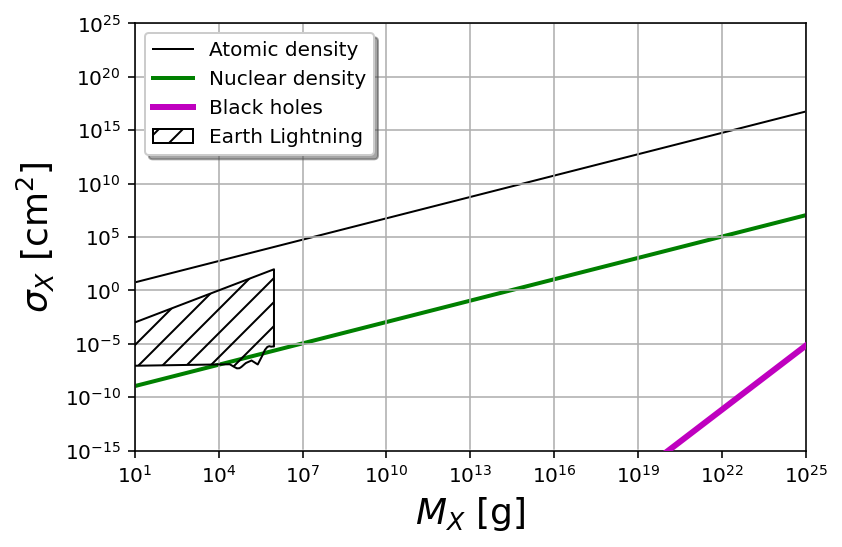

In [10]:
M1 = np.logspace(1, 25)

with plot.constraint_plot(M1, ymin=1e-15):
    plt.fill_between(
        masslightning, sigmalightning, upperlightning,
        where=None, 
        facecolor='none',
        edgecolor='black',
        hatch="//",
        alpha=1.0,
        zorder=8,
        label="Earth Lightning"
    )

plt.show();

## Jupiter

In [11]:
jupitermasslightning = masslightning[:] * 2e3
uppersigmalightningjupiter = jupitermasslightning[:] * 1e-4

print(jupitermasslightning, uppersigmalightningjupiter, sep="\n")

[1.2e+00 5.0e+07 7.0e+07 9.0e+07 1.1e+08 1.3e+08 1.5e+08 1.7e+08 1.9e+08
 3.0e+08 5.0e+08 7.0e+08 9.0e+08 1.1e+09 1.3e+09 1.5e+09 1.7e+09 1.9e+09] g
[1.2e-04 5.0e+03 7.0e+03 9.0e+03 1.1e+04 1.3e+04 1.5e+04 1.7e+04 1.9e+04
 3.0e+04 5.0e+04 7.0e+04 9.0e+04 1.1e+05 1.3e+05 1.5e+05 1.7e+05 1.9e+05] g


In [12]:
# vbar = 0.0 * u.km / u.s
# Vhold = 800.0 * u.km / u.s

# Mx_unit = u.g
# sigma_unit = u.cm**2

# Mhold=[]
# Shold=[]

# sigma_factor = 1e-10 * u.cm**6  # TODO why units?

# # calculate Mx
# for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
#     _v = qnorm(vx, vy, vz)
#     vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)

#     if (vvir < vrel) & (_v <= vesc):  # TODO WHY?
#         maxwellian = f_BM_bin(_v, vbin=v_step, vvir=vvir)  # TODO understand normalization        

#         vbar = vbar + vrel * maxwellian  # cumulative

#         Mx = (1e5/3 * (u.g * u.s / u.m) * vbar).to_value(Mx_unit)  # TODO why?
#         Mhold.append(Mx)

#         Vhold = vrel    # problem? never reset Vhold
# # /for 

# # calculate sigmax
# for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
#     _v = qnorm(vx, vy, vz)
#     vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)
#     if (vvir < vrel) & (_v <= vesc):  # TODO WHY?
#         if Vhold < vrel:
#             vrel = Vhold

#         sigmax = np.power(sigma_factor * (vvir / vrel)**7, 1./3)
#         # if sigmax < ref_sigmax:  # TODO why not this?
#         #     sigmax = ref_sigmax
#         Shold.append(sigmax.to_value(sigma_unit))

#         Vhold = vrel    # problem? never reset Vhold

# # /for

# Mhold = np.array(Mhold) * Mx_unit
# Shold = np.array(Shold) * sigma_unit


In [13]:
# rng = np.array(
#     [i*10**n for n in range(1, 10) for i in range(1, 10)]
# ) * Mhold.unit

# sel = ((rng[:-1, None] < Mhold) & (Mhold < rng[1:, None]))
# inds = np.sum(sel, axis=1) > 0

# M = (rng[:-1]+rng[1:])[inds] / 2
# S = as_quantity([np.min(Shold[s]) for s in sel if np.sum(Shold[s]) > 0])


In [14]:
# sel = S > 6e-8 * u.cm**2  # TODO make a parameter

# jovian_macro = QTable([M[sel], S[sel]], names=["mass", "sigma"])
# jovian_macro[:1]

../src/plot.py:123: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  fill = pyplot.fill_between(



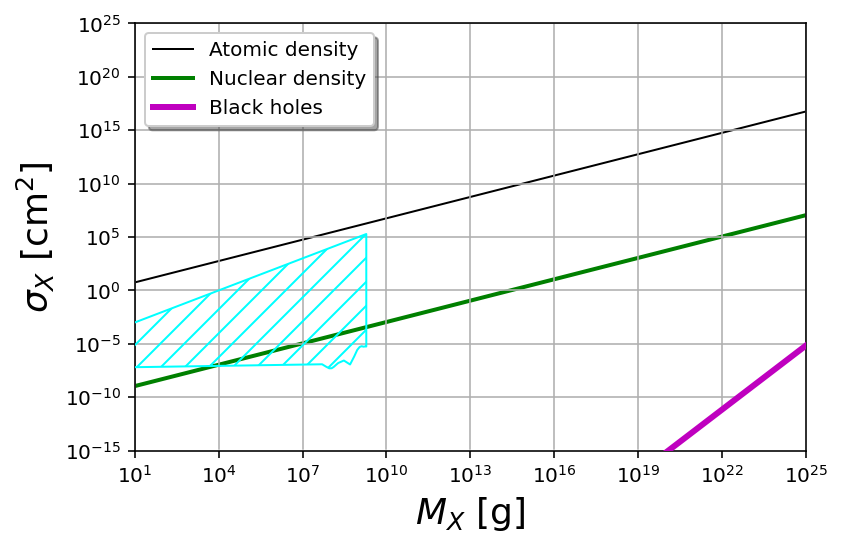

In [15]:
m_arr = np.logspace(1, 25)

with plot.constraint_plot(m_arr, ymin=1e-15):
    plt.fill_between(
        jupitermasslightning,
        sigmalightning,
        uppersigmalightningjupiter,
        where=None,
        facecolor="none",
        edgecolor="cyan",
        hatch="//",
        alpha=1.0,
        zorder=4,
    )

plt.show();

### Plotting Phase Space Constraints

In [16]:
import importlib
importlib.reload(src.plot)
from src import plot

<module 'src.plot' from '../src/plot.py'>

../src/plot.py:123: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  fill = pyplot.fill_between(

../src/plot.py:516: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  bh_fill = pyplot.fill_between(



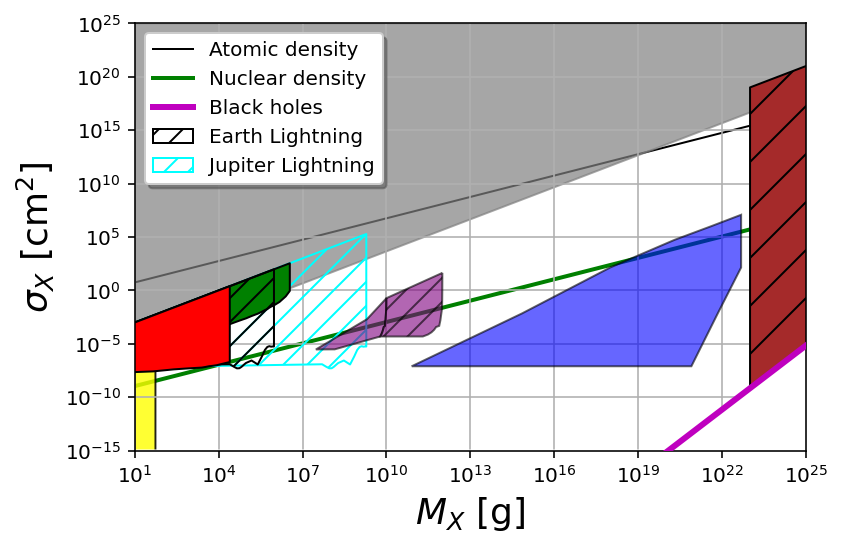

In [17]:
with plot.constraint_plot(
    m_arr=np.logspace(1, 25),
    ymin=1e-15,
    ymax=1e25,
    # previvos constraints
    mica_constr=True,
    WD_constr=True,
    CMB_constr=True,
    superbursts_constr=True,
    humandeath_constr=True,
    dfn_constr=True,
    lensing_constr=True,
    bh_constr=True,
) as (ax, m_arr, ymin, ymax):

    plt.fill_between(
        masslightning, sigmalightning, upperlightning,
        where=None, 
        facecolor='none',
        edgecolor='black',
        hatch="//",
        alpha=1.0,
        zorder=8,
        label="Earth Lightning"
    )
    plt.fill_between(
        jupitermasslightning,
        sigmalightning,
        uppersigmalightningjupiter,
        where=None,
        facecolor="none",
        edgecolor="cyan",
        hatch="//",
        alpha=1.0,
        zorder=4,
        label="Jupiter Lightning"
    )
# /with

plt.show();


<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>